## Import librairies

In [1]:
print ('Importing librairies...')

import os

# Loading and data transfer functions
import pickle
import pandas as pd
import math
import sys
import tqdm

# Array and Dataformating
import numpy as np
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

# Plotting functions
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry.polygon import Polygon as ShapelyPolygon
import matplotlib.pylab as plt
from matplotlib.patches import Circle, Wedge, Polygon

# Gaussian Smoothing Functions
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve


# VFE modules
# from fenics import *
import time as tm
from scipy import signal
# from mshr import *
from multiprocessing import Pool

# Gaussian Smoothing Functions
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import matplotlib.animation as animation
from time import time

from torch import torch
print ('Librairies imported')

Importing librairies...
Librairies imported


## Load reservoir data

In [2]:
Cm0 = 1e-10
case = '_Cm1m10'

directory = '../Simulation_results/Reservoir_model/'

# Extract depth and thickness
Depth_points = np.load(directory + 'Depth_points.npy')
Depth_field = np.load(directory + 'Depth_field.npy')

H_points = np.load(directory + 'H_points.npy')
H_field = np.load(directory + 'H_field.npy')

# Extract mesh of diffusion model
MESH = np.load(directory + 'MESH.npy')*1e-3

xmin = np.min(MESH[:,0])*1e3
xmax = np.max(MESH[:,0])*1e3
ymin = np.min(MESH[:,1])*1e3
ymax = np.max(MESH[:,1])*1e3

print(xmin, xmax, ymin, ymax)

N_width = 40 # Number of blocks we want along width (x)
ratio = (ymax-ymin)/(xmax-xmin) # Ratio between length and width of diffusion meshgrid

XMesh = []
for i in range(int(N_width*ratio)):
    XMesh_tamp = [xmin+(xmax-xmin)*j/(N_width-1) for j in range(N_width)]
    XMesh.append(XMesh_tamp)
YMesh = []
for i in range(int(N_width*ratio)):
    YMesh_tamp = [ymin+(ymax-ymin)*i/(int(N_width*ratio)-1) for j in range(N_width)]
    YMesh.append(YMesh_tamp)

XMesh = np.array(XMesh) ; YMesh = np.array(YMesh)

block_size=(xmax-xmin)*1e3/N_width

# Interpolate data
X_, Y_ = np.meshgrid(np.array(XMesh)[0], np.array(YMesh)[:,0])

interp = RBFInterpolator(H_points, H_field)
Thick = interp(MESH*1e3)
Thick = griddata(MESH*1e3, Thick, (X_, Y_), method='linear')

interp = RBFInterpolator(Depth_points, Depth_field)
Depth = interp(MESH*1e3)
Depth = griddata(MESH*1e3, Depth, (X_, Y_), method='linear')

0.0 110000.0 30000.0 150000.0


# Recreate RESDictionary from diffusion model data
### This step can be skipped if 'diffusion_model.ipynb' directly returns the pickle file 'RESDictionary.p'

In [3]:
# assign directory
directory = '../Simulation_results/Reservoir_model/RES_data/'
output_folder = '../Simulation_results/Mechanical_model/'
keys2=[]
RES = {}

from os.path import exists

# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if filename[-4:] == '.npy':
        print(filename)
        keys2.append(filename[:-4])
        RES[filename[:-4]]=np.load(f,allow_pickle=True)
        if filename == 'RES.npy':
            RES['RES']=RES['RES'].item()
    elif filename[-4:] == '.csv':
        print(filename)
        keys2.append(filename[:-4])
        RES[filename[:-4]]=pd.read_csv(f)
        
        
X, Y = RES['X'],RES['Y'] #np.meshgrid(np.linspace(np.min(RES['X']),np.max(RES['X']),50), np.linspace(np.min(RES['Y']),np.max(RES['Y']),54))
Thickness = RES['RES']['Thickness']#np.load(folder_name + 'ReservoirThickness.npy') / 1000 #dim change
Outline = RES['Outline'][['X','Y']]

# Manually define compressibility
CM_grd = np.array([[Cm0 for j in range(N_width)] for i in range(int(N_width*ratio))])

RES['X'] = XMesh
RES['Y'] = YMesh
RES['RES']['Thickness'] = Thick
RES['RES']['Depth'] = Depth
RES['Cm'] = {}
RES['Cm']['RAD'] = CM_grd
RES['Cm']['OL'] = CM_grd
RES['Cm']['InSARGPS']= CM_grd

np.save(output_folder + 'RESDictionary.npy',RES)

RES.npz.npy
Outline.csv
RES.npy
X.npy
Y.npy


## Create reservoir object

In [4]:
block_size = 2500
from util.stress_strain_v3 import create_reservoir_object
rsrvr = create_reservoir_object(output_folder + 'RESDictionary.npy', block_size=block_size)


Creating Reservoir object... 

Observation Points Boundary Check: 100%|███████████████████████████| 1720/1720 [00:00<00:00, 2266.91it/s]

[DONE]


In [5]:
# Pass the compressibility to the reservoir object
rsrvr.BLOCKS.Cm = np.nanmean(CM_grd)
for key in rsrvr.RES['Cm'].keys():
    rsrvr.RES['Cm'][key] = np.ones_like(rsrvr.RES['Cm']['InSARGPS'])*CM_grd


## Load Pressure history

100%|████████████████████████████████████████████████████████████████████| 62/62 [00:27<00:00,  2.28it/s]


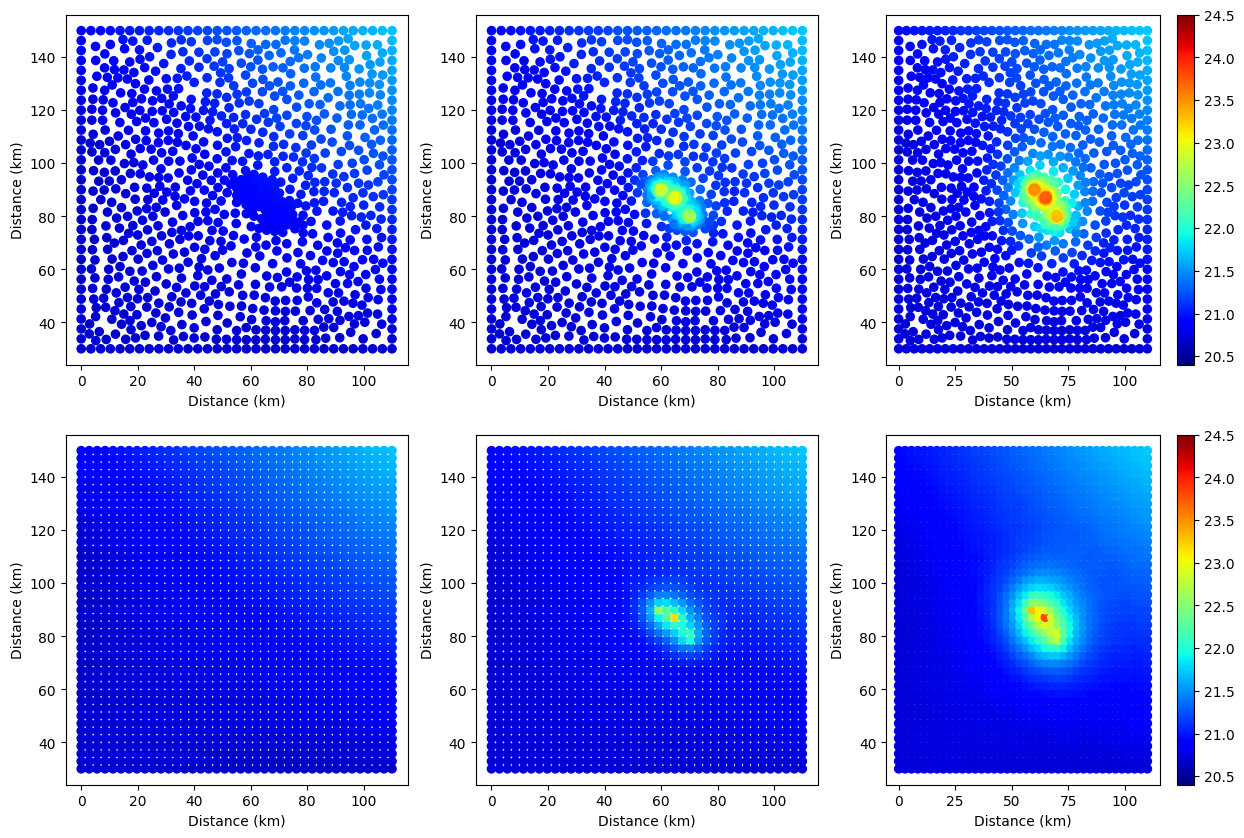

In [6]:
directory = '../Simulation_results/Reservoir_model/'
old_pressures_list = np.load(directory + 'avg_pressure_list.npy', allow_pickle=True)

xnew = np.linspace(xmin/1e3,xmax/1e3,num=int(N_width))
ynew = np.linspace(ymin/1e3,ymax/1e3,num=int(N_width*ratio))
Xnew,Ynew = np.meshgrid(xnew,ynew)
New_mesh = np.vstack([Xnew.flatten(),Ynew.flatten()]).T

New_pressure_list =[]
for i in tqdm.tqdm(range(len(old_pressures_list))):
    interp = RBFInterpolator(MESH, old_pressures_list[i])
    New_pressure = interp(New_mesh)
    New_pressure_list.append(New_pressure)
pressures_list = New_pressure_list


plot_iterations = [0, 20, 60]
times = ['Initial situation', '1.31 years', '4.81 years']
fig, axs = plt.subplots(2, len(plot_iterations), figsize=(5*len(plot_iterations),10))
for ii in range(len(plot_iterations)):
    ax = axs[0,ii]
    im=ax.scatter(MESH[:,0],MESH[:,1],c=old_pressures_list[plot_iterations[ii]]/1e6,cmap='jet', vmin = 20.4, vmax=24.5, s=35)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')
plt.colorbar(im,ax = ax)

for ii in range(len(plot_iterations)):
    ax = axs[1,ii]
    im=ax.scatter(New_mesh[:,0],New_mesh[:,1],c=pressures_list[plot_iterations[ii]]/1e6,cmap='jet', vmin = 20.4, vmax=24.5, s=35)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')
plt.colorbar(im,ax = ax)


## Creation of the Green's functions, subsidence matrix, and match it to the BorisBlocks mesh

In [7]:
compute_GF = 1 # toggle computation of Green's functions on/off
# if on, it will calclulate the Green's functions again

if compute_GF:
    from util.stress_strain_v3 import  compute_green_functions
    #Compute the Green's functions, and store it in reservoir_data. You just need to create them once, and then you can toggle off the computation
    compute_green_functions(output_folder,rsrvr)
else:
    rsrvr.StrainVolume.Disp = torch.load(output_folder+'G_matrix_disp.pt')
    rsrvr.StrainVolume.σ = torch.load(output_folder+'G_matrix_sigma.pt')

Computing GreenFunction
Computing Strains for Blocks to Points
  Total of 1720 Blocks
  Total of 1720 Points


Computing Disp and σ: 100%|█████████████████████████████████████████| 1720/1720 [00:09<00:00, 182.55it/s]


Greens functions saved to ../Simulation_results/Mechanical_model/ folder


In [8]:
compute_C = 1 # toggle computation of subsidence matrix C on/off
# if on, it will calclulate the subsidence matrix again; if off it will try to load it from the specified file

if compute_C:
    from util.subsidence_matrix import create_subsidence_matrix
    # Creates the matrix by which you multiply the pressure to get the subsidence

    G_vertical_displacement = rsrvr.StrainVolume.Disp.cpu().detach().numpy()[:,:,2]
    #np.load('reservoir_data/SurfaceGreensFunction_vertical_displacement_only.npy')
    C_matrix = create_subsidence_matrix(New_mesh, RES, CM_grd, rsrvr.BLOCKS, G_vertical_displacement, block_size,folder=output_folder)
    del G_vertical_displacement

## Calculate surface deformation

In [9]:
# parameters for the loop:
iteration_start = 0; iteration_end = len(pressures_list) #One iteration = one month, here you can choose from which iteration to which to compute displacements and stresses
# displacement calculation function
#Defining the displacement function
displacement = lambda pressure_array : np.matmul(np.array(C_matrix), pressure_array)

#Init the deformations 
deformations_list = [[] for ii in range(iteration_start,iteration_end)]
#Compute deformations
t_begin = time()
for ii in tqdm.tqdm(range(iteration_start,iteration_end)): #tqdm is used for the progress bar
    deformations_list[ii] = displacement(np.array(pressures_list[ii]))
t_end = time()

print ('Deformations calculated, total time = {} s, time per iteration = {} s'.format(t_end-t_begin,(t_end-t_begin)/(iteration_end-iteration_start)))

100%|███████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 214.45it/s]

Deformations calculated, total time = 0.29981112480163574 s, time per iteration = 0.0048356633032521894 s


# Some plots
### Plot Depth and Thickness

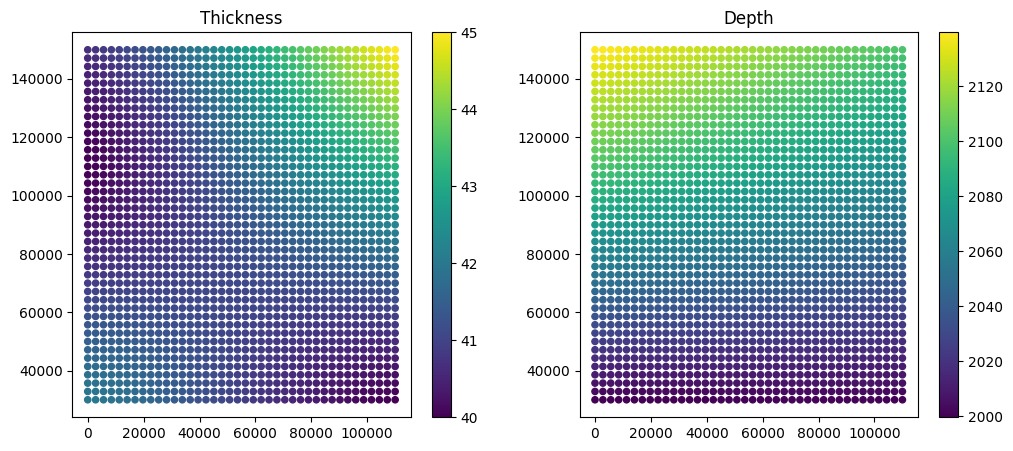

In [10]:
plt.subplots(1, 2, figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title('Thickness')
plt.colorbar(plt.scatter(rsrvr.BLOCKS.X,rsrvr.BLOCKS.Y,c=Thick,cmap='viridis', s=20))

plt.subplot(1, 2, 2)
plt.title('Depth')
plt.colorbar(plt.scatter(rsrvr.BLOCKS.X,rsrvr.BLOCKS.Y,c=Depth,cmap='viridis', s=20))

### Plot pressure and deformation

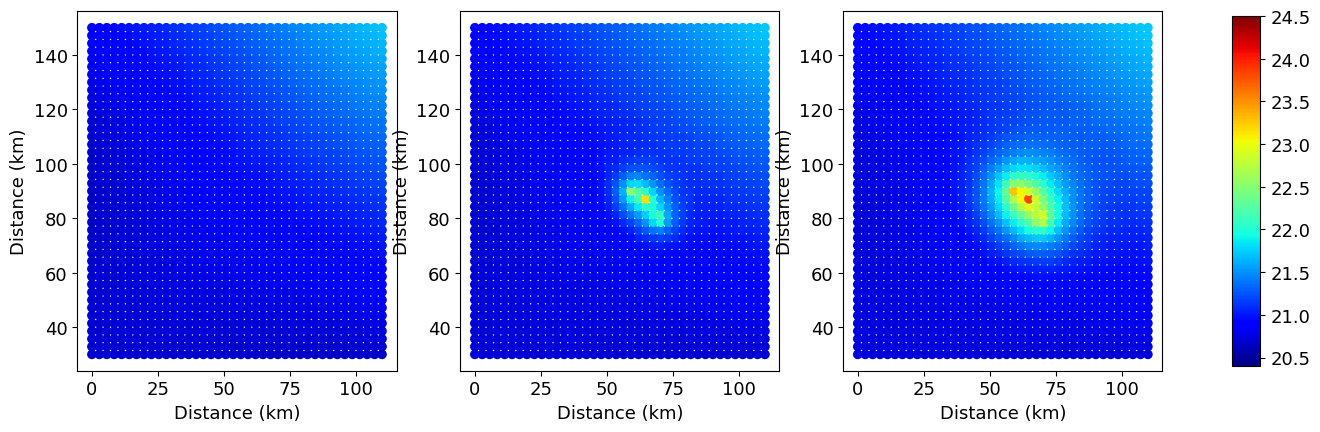

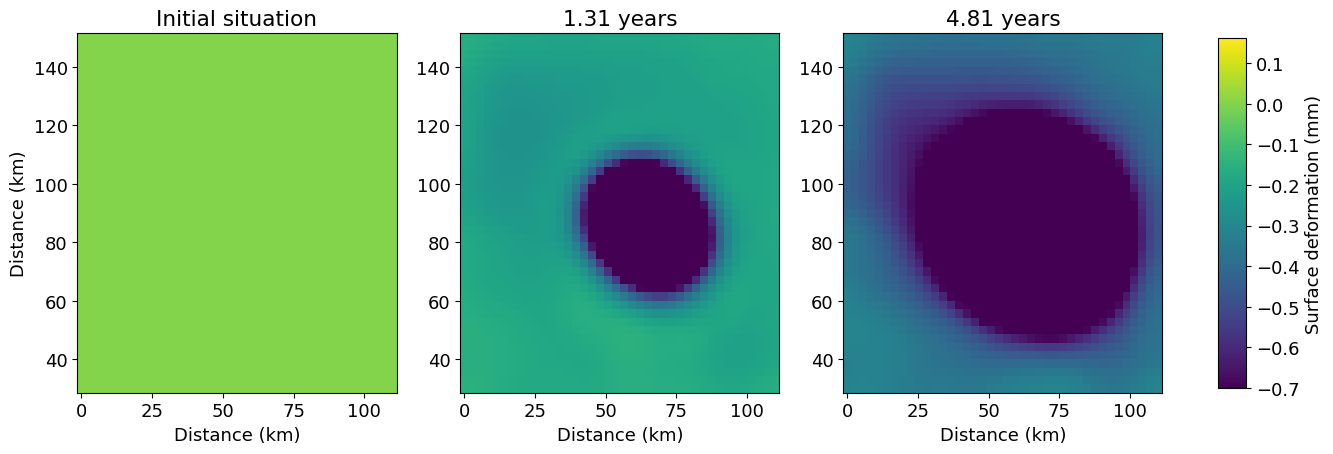

In [11]:
plt.rcParams.update({'font.size': 13})
import scipy
sigma = np.nanmean(RES['RES']['Depth'])*1e-3 # big sigma reduces the subsidence (absolute value)


max_def = 1e3*np.nanmax(deformations_list - (deformations_list[0]))
min_def = -0.0007*1e3 #np.nanmin(deformations_list - (deformations_list[0]))

plot_iterations = [0, 20, 60]
times = ['Initial situation', '1.31 years', '4.81 years']
eps = 1
fig1, ax = plt.subplots(1, len(plot_iterations), figsize=(14, 14/len(plot_iterations)))
for ii in range(len(plot_iterations)):
    im=ax[ii].scatter(New_mesh[:,0],New_mesh[:,1],c=pressures_list[plot_iterations[ii]]/1e6,cmap='jet',vmin = 20.4, vmax=24.5, s=35)
    ax[ii].set_xlabel('Distance (km)')
    ax[ii].set_ylabel('Distance (km)')
    
cb_ax = fig1.add_axes([0.95, 0.12, 0.02, 0.75])
fig1.colorbar(im, cax=cb_ax)

fig2, ax = plt.subplots(1, len(plot_iterations), figsize=(14, 14/len(plot_iterations)))
for ii in range(len(plot_iterations)):
    field = np.reshape(deformations_list[plot_iterations[ii]]-deformations_list[0],(int(N_width*ratio),N_width))
    # smooth the field
    smoothed_field = scipy.ndimage.gaussian_filter(field, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    im=ax[ii].pcolormesh(XMesh[0]*1e-3,YMesh[:,0]*1e-3, smoothed_field*1e3, vmin=min_def, vmax=max_def)#
    ax[ii].set_xlabel('Distance (km)')
    ax[0].set_ylabel('Distance (km)')
    ax[ii].set_title(times[ii])
cb_ax = fig2.add_axes([0.94, 0.12, 0.02, 0.75])
fig2.colorbar(im, cax=cb_ax, label='Surface deformation (mm)')

In [12]:
# Export subsidence
output_directory = output_folder 
subsidence = {}
subsidence['Xmesh'] = XMesh
subsidence['Ymesh'] = YMesh
subsidence['unfilt_subsidence'] = np.array([deformation.reshape(XMesh.shape) for deformation in deformations_list])
np.save(output_directory+'subsidence',subsidence,allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../Simulation_results/Mechanical_model/_Cm1m10/subsidence.npy'